In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from seaborn import heatmap
from tqdm import tqdm
from scipy.stats import norm


## Price Transition Matrix

We demonstrate DP on 3 market price transition assumptions:
* Uniform (Market Random / Max volatility)
* Random Walk
* Random Walk w/ regularization to some market equilibrium price (that may or may not p_subj)

In [2]:
def make_transition_matrix(fair_value, volatility, mean_reversion=0.2, n_prices=99):
    """
    Random walk in log-odds space with mean reversion:
      L_t = log(c_t / (1 - c_t))
      L_{t+1} = L_t + k*(L_fair - L_t) + e, e ~ N(0, sigma^2)
      c_{t+1} = 1 / (1 + exp(-L_{t+1}))
    
    Parameters:
    -----------
    fair_value : float
        Long-term mean in probability space
    volatility : float
        Std dev of shocks in log-odds space
    mean_reversion : float
        Speed of mean reversion (0 = no reversion, 1 = instant)
    n_prices : int
        Number of price grid points
    """
    # Price grid
    prices = np.linspace(0, 1, n_prices)
    prices_safe = np.clip(prices, .01, .99)
    
    # Convert fair_value to log-odds
    L_fair = np.log(fair_value / (1 - fair_value))
    
    # Build transition matrix
    M = np.zeros((n_prices, n_prices))
    
    for i, c_t in enumerate(prices_safe):
        # Current log-odds
        L_t = np.log(c_t / (1 - c_t))
        
        L_next_mean = L_t + mean_reversion * (L_fair - L_t)
        
        # Next price distribution in log-odds space
        L_grid = np.log(prices_safe / (1 - prices_safe))
        pdf_logit = norm.pdf(L_grid, loc=L_next_mean, scale=volatility)
        
        # Jacobian: dL/dc = 1/(c*(1-c))
        jacobian = 1 / (prices_safe * (1 - prices_safe))
        pdf_prob = pdf_logit * jacobian
        
        # Normalize
        pdf_prob = np.maximum(pdf_prob, 1e-10)
        M[i, :] = pdf_prob / pdf_prob.sum()
    
    return M

Text(50.722222222222214, 0.5, 'Current Price')

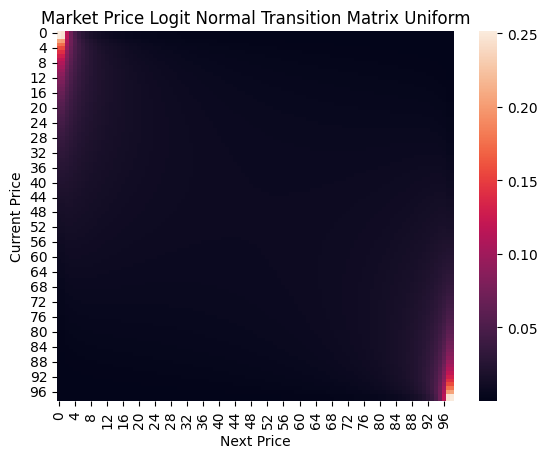

In [3]:
plt.title("Market Price Logit Normal Transition Matrix Uniform") # But 0 and 1 are absorbing states since they wouldnt be reached unless something is something absolutely is/isn't going to happen
heatmap(make_transition_matrix(.5,2,mean_reversion=0,n_prices=99))
plt.xlabel("Next Price")
plt.ylabel("Current Price")

Text(50.722222222222214, 0.5, 'Current Price')

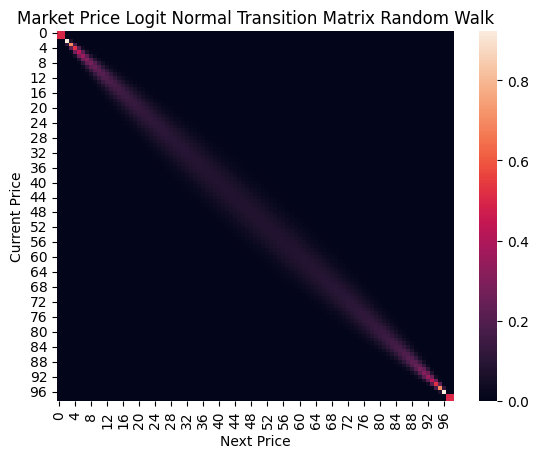

In [4]:
plt.title("Market Price Logit Normal Transition Matrix Random Walk")    
heatmap(make_transition_matrix(.7,.2,mean_reversion=0,n_prices=99))
plt.xlabel("Next Price")
plt.ylabel("Current Price")

Text(50.722222222222214, 0.5, 'Current Price')

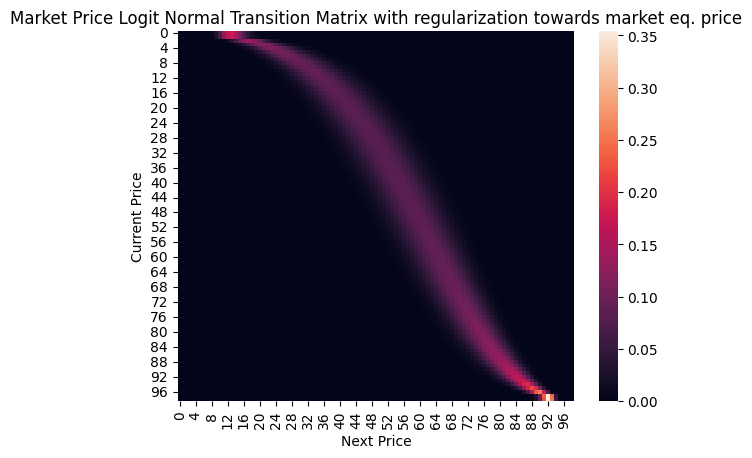

In [5]:
plt.title("Market Price Logit Normal Transition Matrix with regularization towards market eq. price")   
heatmap(make_transition_matrix(.7,.2,mean_reversion=.5,n_prices=99))
plt.xlabel("Next Price")
plt.ylabel("Current Price")

## DP Code

In [6]:
def run_dp(
    model_trans: np.ndarray,
    p_subj: float,
    gamma_b: float = 0.05,
    gamma_s: float = 0.10,
    T: int = 20,
    n_theta: int = 51,
    n_b: int = 51,
    n_prices: int = 99
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Dynamic programming for optimal binary options trading with transaction costs.
    
    Args:
        model_trans: Transition matrix [n_prices, n_prices], model_trans[i,j] = P(price_j | price_i)
        p_subj: Subjective probability of contract paying out (0-1)
        gamma_b: Transaction cost for buying (fraction of mid price)
        gamma_s: Transaction cost for selling (fraction of mid price)  
        T: Number of time steps (including terminal)
        n_theta: Grid size for portfolio fraction in contracts
        n_b: Grid size for target allocation
        n_prices: Grid size for contract prices
        
    Returns:
        V: Value function [T+1, n_theta, n_prices]
        policy: Optimal target allocation [T, n_theta, n_prices]
    """
    
    # ========== STATE/ACTION GRIDS ==========
    theta_grid = np.linspace(0, 0.99, n_theta)      # Portfolio fraction in contracts
    price_grid = np.linspace(0.01, 0.99, n_prices)  # Contract mid prices
    b_grid = np.linspace(0, 0.99, n_b)              # Target allocation
    
    # ========== PRE-COMPUTE THETA_NEXT INDICES ==========
    # R_matrix[i,j] = price_grid[j] / price_grid[i] = c_next / c_current
    R_matrix = price_grid[None, :] / price_grid[:, None]
    
    # theta_next_idx[b, current_price, next_price] -> theta grid index
    theta_next_idx = np.zeros((n_b, n_prices, n_prices), dtype=np.int16)
    
    for i_b, b in enumerate(b_grid):
        b_safe = np.clip(b, 1e-12, 1 - 1e-12)
        numerator = R_matrix * b_safe
        denominator = 1 - b_safe + numerator + 1e-12
        theta_next_vals = np.clip(numerator / denominator, 0, 1)
        
        # Convert to grid indices
        idxs = (theta_next_vals * (n_theta - 1) + 0.5).astype(int)
        theta_next_idx[i_b] = np.clip(idxs, 0, n_theta - 1)
    
    # ========== IMMEDIATE REWARDS WITH TRANSACTION COSTS ==========
    theta_2d = theta_grid[:, None]  # (n_theta, 1)
    b_2d = b_grid[None, :]          # (1, n_b)
    
    # Buying: b > theta
    buy_mask = b_2d > theta_2d + 1e-8
    buy_reward = np.log(np.clip(1 - theta_2d - (b_2d - theta_2d) * (1 + gamma_b), 1e-12, np.inf))
    
    # Selling: b < theta  
    sell_mask = b_2d < theta_2d - 1e-8
    sell_reward = np.log(np.clip(1 - theta_2d - (b_2d - theta_2d) * (1 - gamma_s), 1e-12, np.inf))
    
    # No trade: b = theta
    hold_reward = np.log(np.clip(1 - theta_2d, 1e-12, np.inf))
    
    immediate = np.where(buy_mask, buy_reward, 
                        np.where(sell_mask, sell_reward, hold_reward))
    
    # ========== DP TABLES ==========
    V = np.zeros((T + 1, n_theta, n_prices))
    policy = np.zeros((T, n_theta, n_prices))
    
    # ========== TERMINAL CONDITION ==========
    Theta, C = np.meshgrid(theta_grid, price_grid, indexing='ij')
    mask = Theta > 1e-20
    V_terminal = np.zeros_like(Theta)
    V_terminal[mask] = p_subj * np.log(1 + Theta[mask] / (C[mask] * (1 - Theta[mask])))
    V[T] = V_terminal
    
    # ========== CURRENT PERIOD COST ==========
    current_cost = -np.log(np.clip(1 - theta_grid, 1e-12, None))
    
    # ========== BACKWARD INDUCTION ==========
    for t in tqdm(reversed(range(T)), total=T, desc="DP backward induction"):
        if t == T - 1:
            # Last trading period: next period is settlement
            settle_idx = np.clip((b_grid * (n_theta - 1) + 0.5).astype(int), 0, n_theta - 1)
            
            for i_c in range(n_prices):
                settle_vals = V[T, settle_idx, i_c]  # Terminal values for each b
                total_vals = current_cost[:, None] + immediate + settle_vals[None, :]
                best_b_idx = np.argmax(total_vals, axis=1)
                V[t, :, i_c] = total_vals[np.arange(n_theta), best_b_idx]
                policy[t, :, i_c] = b_grid[best_b_idx]
                
        else:
            # Normal periods: precompute expected future values
            V_next = V[t + 1]
            expected_future = np.zeros((n_b, n_prices))
            
            # Precompute E[V_next | b, current_price] for all (b, price) pairs
            for i_b in range(n_b):
                for i_c in range(n_prices):
                    trans_probs = model_trans[i_c, :]
                    theta_idx = theta_next_idx[i_b, i_c, :]
                    v_vals = V_next[theta_idx, np.arange(n_prices)]
                    expected_future[i_b, i_c] = np.dot(trans_probs, v_vals)
            
            # Optimized inner loop: vectorize over theta for each price
            for i_c in range(n_prices):
                exp_future_for_price = expected_future[:, i_c]
                total_vals = current_cost[:, None] + immediate + exp_future_for_price[None, :]
                best_b_idx = np.argmax(total_vals, axis=1)
                V[t, :, i_c] = total_vals[np.arange(n_theta), best_b_idx]
                policy[t, :, i_c] = b_grid[best_b_idx]
    
    return V, policy

## #1 DP on Uniform Price Transitions

DP backward induction: 100%|██████████| 31/31 [00:00<00:00, 434.03it/s]


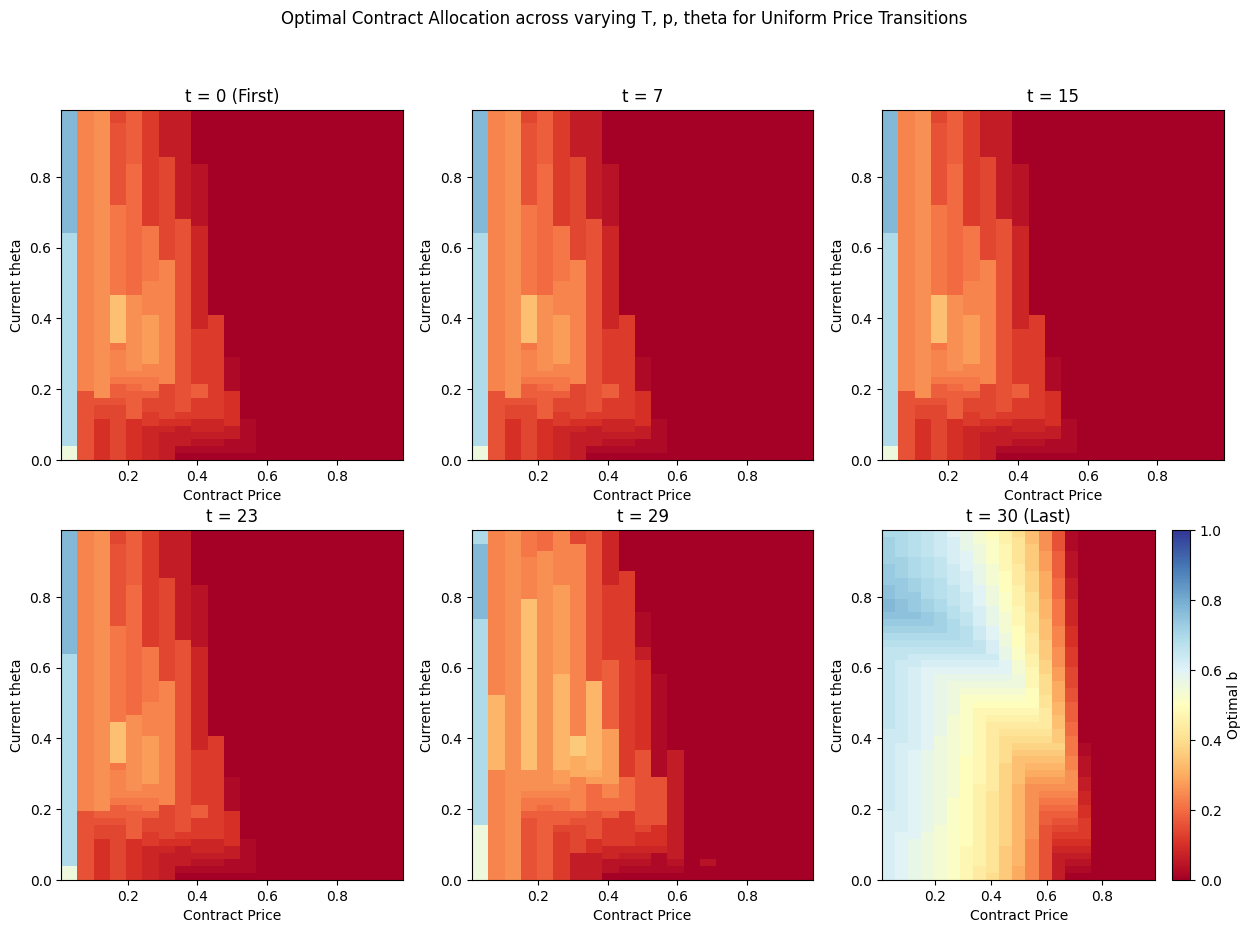

In [7]:
# Sample Policy 1: Uniform Price Transitions

T = 31
n_prices = 21
psub = .7
V, policy = run_dp(make_transition_matrix(psub,2,mean_reversion=0,n_prices=n_prices),
                             p_subj=psub,
                             T = T,
                             gamma_b = 0.05,    
                             gamma_s = 0.10,
                             n_theta = 51,
                             n_b = 51,
                             n_prices = n_prices)

# Create heatmaps for key time points
key_times = [0, T//4, T//2, 3*T//4, T-2, T-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, t in enumerate(key_times):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(policy[t], 
                   aspect='auto',
                   origin='lower',
                   extent=[0.01, 0.99, 0.0, 0.99],  # Price: 0.01-0.99, Theta: 0.0-0.99
                   vmin=0, vmax=1,
                   cmap='RdYlBu')
    
    ax.set_xlabel('Contract Price')
    ax.set_ylabel('Current theta')
    ax.set_title(f't = {t}' + (' (First)' if t == 0 else ' (Last)' if t == T-1 else ''))
    
    # Add colorbar only to last plot
    if idx == len(key_times) - 1:
        fig.colorbar(im, ax=ax, label='Optimal b')

plt.suptitle("Optimal Contract Allocation across varying T, p, theta for Uniform Price Transitions")
plt.show()


Policy is conservative, allocating very little except when contract price is at a minimum. Note that last time step's policy will always be the same since it is just greedy Kelly

This makes sense because the model expects extreme volatility now to continue onwards, so it's likely a contract price as cheap / cheaper will come about

## #2 DP on Random Walk Price Transitions

DP backward induction: 100%|██████████| 31/31 [00:00<00:00, 417.28it/s]


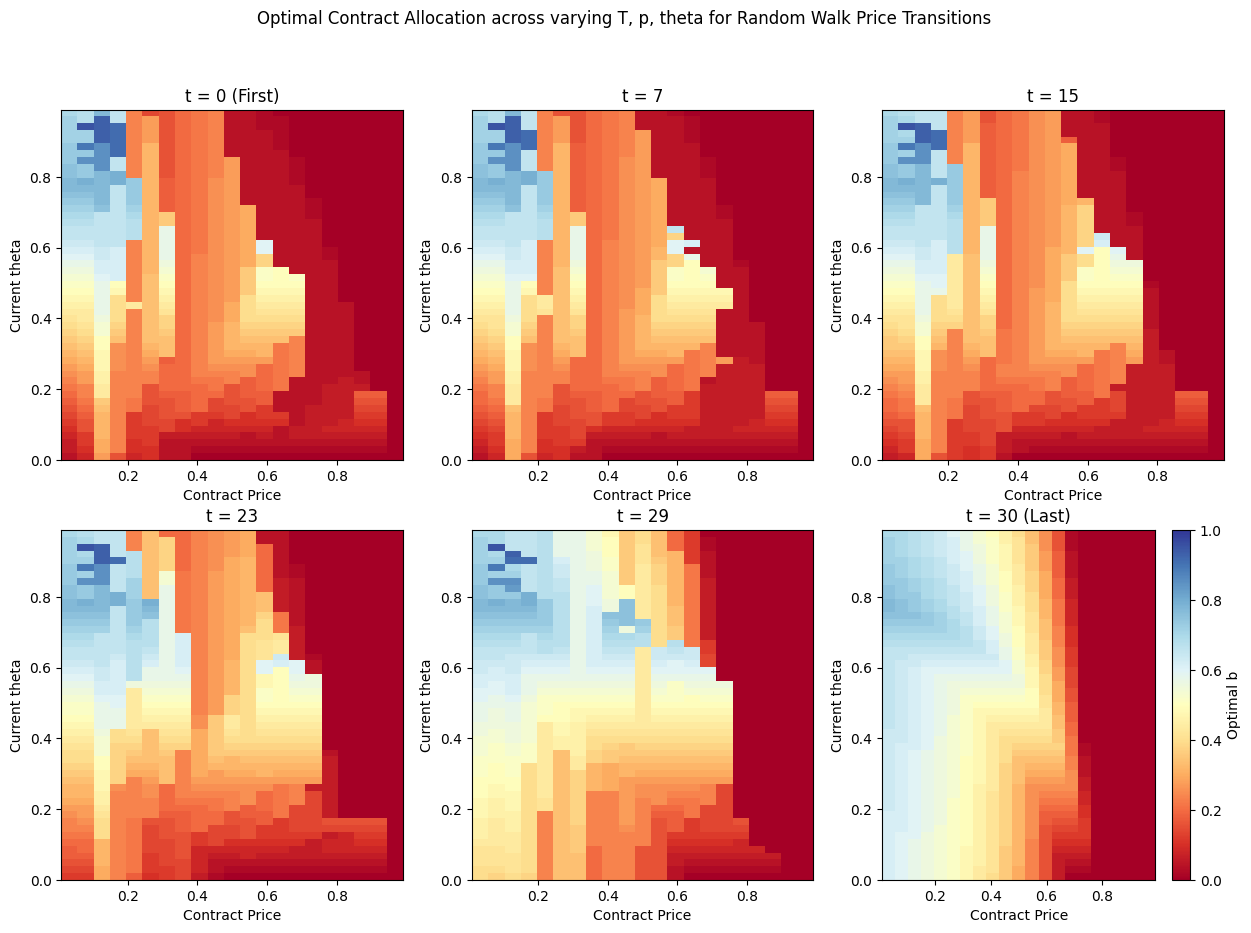

In [8]:
# Sample Policy 2: Random Walk Price Transitions

T = 31
n_prices = 21
psub = .7
V, policy = run_dp(make_transition_matrix(psub,.2,mean_reversion=0,n_prices=n_prices),
                             p_subj=psub,
                             T = T,
                             gamma_b = 0.05,
                             gamma_s = 0.10,
                             n_theta = 51,
                             n_b = 51,
                             n_prices = n_prices)

# Create heatmaps for key time points
key_times = [0, T//4, T//2, 3*T//4, T-2, T-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, t in enumerate(key_times):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(policy[t], 
                   aspect='auto',
                   origin='lower',
                   extent=[0.01, 0.99, 0.0, 0.99],  # Price: 0.01-0.99, Theta: 0.0-0.99
                   vmin=0, vmax=1,
                   cmap='RdYlBu')
    
    ax.set_xlabel('Contract Price')
    ax.set_ylabel('Current theta')
    ax.set_title(f't = {t}' + (' (First)' if t == 0 else ' (Last)' if t == T-1 else ''))
    
    # Add colorbar only to last plot
    if idx == len(key_times) - 1:
        fig.colorbar(im, ax=ax, label='Optimal b')

plt.suptitle("Optimal Contract Allocation across varying T, p, theta for Random Walk Price Transitions")
plt.show()


Policy is to allocate when price is cheap, but also save dry powder for cheaper prices (similar to #1). Also when t << T, buys contracts > p_subj because of possible future higher market prices.

## #3 DP on Random Walk Price Transitions with Regularization /reversion to market eq. price

DP backward induction: 100%|██████████| 31/31 [00:00<00:00, 436.47it/s]


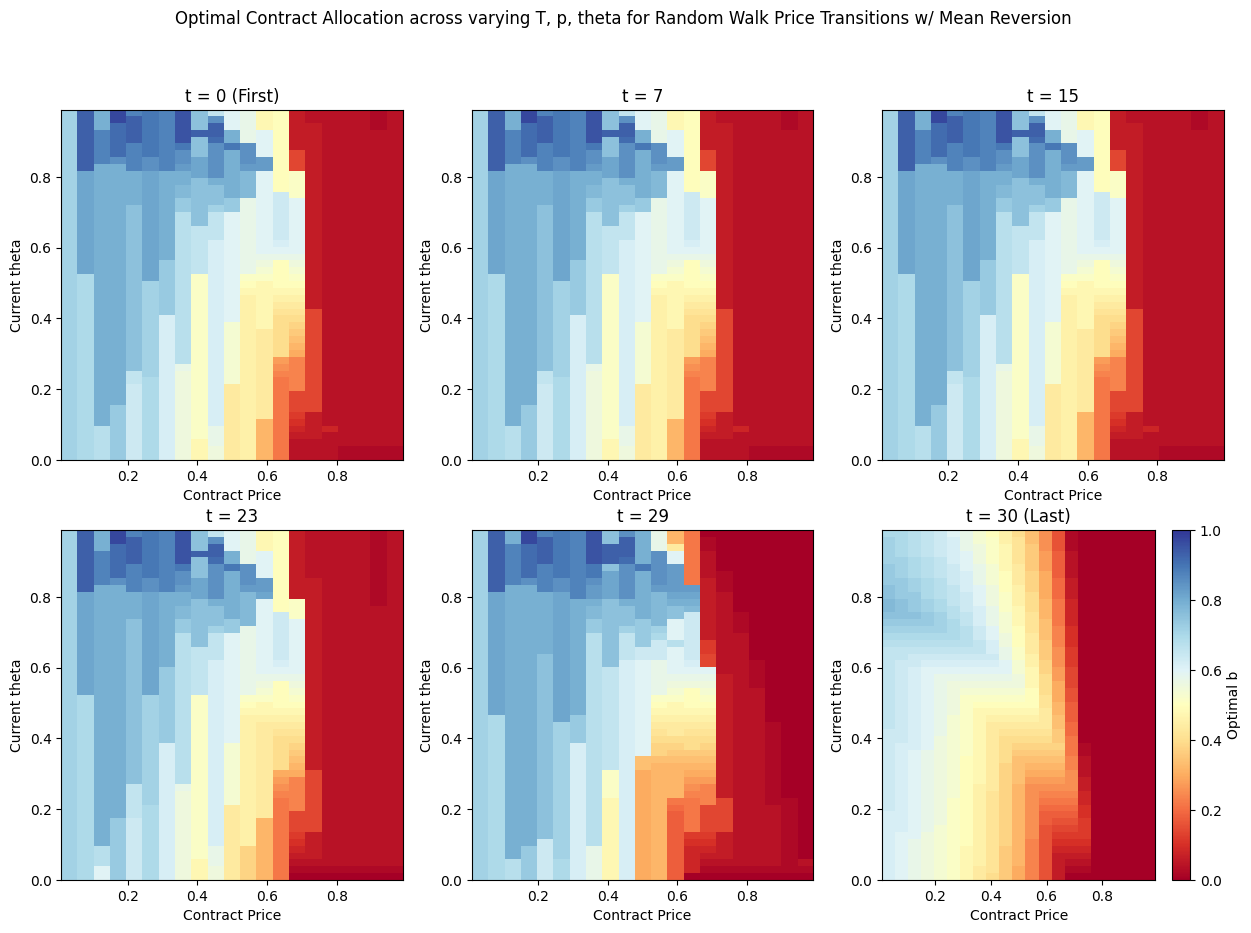

In [9]:
# Sample Policy 3: Random Walk Price Transitions w/ Mean Reversion

T = 31
n_prices = 21
psub = .7

V, policy = run_dp(make_transition_matrix(psub,.2,mean_reversion=0.8,n_prices=n_prices),
                             p_subj=psub,
                             T = T,
                             gamma_b = 0.05,
                             gamma_s = 0.10,
                             n_theta = 51,
                             n_b = 51,
                             n_prices = n_prices)

# Create heatmaps for key time points
key_times = [0, T//4, T//2, 3*T//4, T-2, T-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, t in enumerate(key_times):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(policy[t], 
                   aspect='auto',
                   origin='lower',
                   extent=[0.01, 0.99, 0.0, 0.99],  # Price: 0.01-0.99, Theta: 0.0-0.99
                   vmin=0, vmax=1,
                   cmap='RdYlBu')
    
    ax.set_xlabel('Contract Price')
    ax.set_ylabel('Current theta')
    ax.set_title(f't = {t}' + (' (First)' if t == 0 else ' (Last)' if t == T-1 else ''))
    
    # Add colorbar only to last plot
    if idx == len(key_times) - 1:
        fig.colorbar(im, ax=ax, label='Optimal b')

plt.suptitle("Optimal Contract Allocation across varying T, p, theta for Random Walk Price Transitions w/ Mean Reversion")
plt.show()


Similar policy to #2, but model now allocates much more earlier on, idea being cheap contracts are more rare since they market prices revert to equilibrium faster. 
The policy to buy contracts higher than p_subj also disappears because market price transition probabilities are all pulled towards market eq. price

## #4 DP on Random Walk Price Transitions with Regularization /reversion to market eq. price NO SPREAD

DP backward induction: 100%|██████████| 31/31 [00:00<00:00, 234.29it/s]


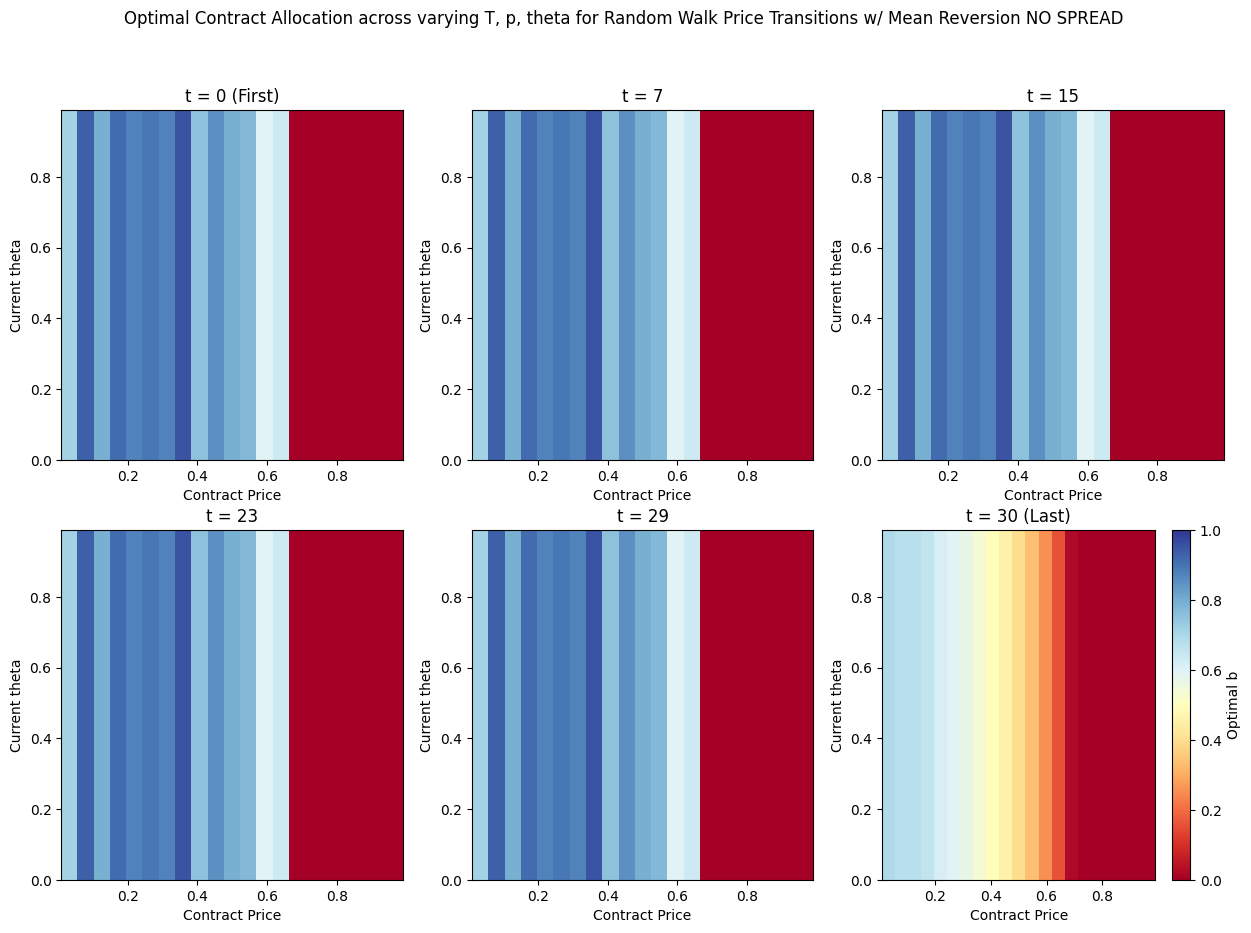

In [10]:
# Sample Policy 3: Random Walk Price Transitions w/ Mean Reversion

T = 31
n_prices = 21
psub = .7

V, policy = run_dp(make_transition_matrix(psub,.2,mean_reversion=0.8,n_prices=n_prices),
                             p_subj=psub,
                             T = T,
                             gamma_b = 0,
                             gamma_s = 0,
                             n_theta = 51,
                             n_b = 51,
                             n_prices = n_prices)

# Create heatmaps for key time points
key_times = [0, T//4, T//2, 3*T//4, T-2, T-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, t in enumerate(key_times):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(policy[t], 
                   aspect='auto',
                   origin='lower',
                   extent=[0.01, 0.99, 0.0, 0.99],  # Price: 0.01-0.99, Theta: 0.0-0.99
                   vmin=0, vmax=1,
                   cmap='RdYlBu')
    
    ax.set_xlabel('Contract Price')
    ax.set_ylabel('Current theta')
    ax.set_title(f't = {t}' + (' (First)' if t == 0 else ' (Last)' if t == T-1 else ''))
    
    # Add colorbar only to last plot
    if idx == len(key_times) - 1:
        fig.colorbar(im, ax=ax, label='Optimal b')

plt.suptitle("Optimal Contract Allocation across varying T, p, theta for Random Walk Price Transitions w/ Mean Reversion NO SPREAD")
plt.show()


Without spread, optimal allocation becomes independent of current allocation (since essentially we are allowed to sell all our contracts and buy them again at the same time step), so we see only vertical lines below.

This means that spreads don't just simply reduce trading activity, they represent a form of cost of making large jumps in positions, which makes our policy path dependent. 